# Foreward

This Notebook prepares the training data set for this project. 

The data is downloaded from [this link](https://github.com/AleksandarMitrevski/se-requirements-classification/tree/master/1-exploratory-analysis/data)

In [15]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [16]:
raw_data_path = r'../data/PROMISE_exp.csv'

The data is organised by `ProjectID`. One project is one set of system requirements.

Each project has a number of system requirements associated with it. `RequirementID` is the ID of each requirement for each project. 

`RequirementText` is the text of the requirement.

In [17]:
df = pd.read_csv(raw_data_path)
df = df.drop('_class_', axis=1)
df['RequirementID'] = df.groupby('ProjectID').cumcount() + 1
df = df[['ProjectID', 'RequirementID', 'RequirementText']]
df.head()

,ProjectID,RequirementID,RequirementText
0,1,1,The system shall refresh the display every 60 seconds.
1,1,2,The application shall match the color of the schema set forth by Department of Homeland Security
2,1,3,If projected the data must be readable. On a 10x10 projection screen 90% of viewers must be able to read Event / Activity data from a viewing distance of 30
3,1,4,The product shall be available during normal business hours. As long as the user has access to the client PC the system will be available 99% of the time during the first six months of operation.
4,1,5,If projected the data must be understandable. On a 10x10 projection screen 90% of viewers must be able to determine that Events or Activities are occuring in current time from a viewing distance of 100


In [18]:
#show the number of requirements for each project
requirement_distribution = df.groupby('ProjectID', as_index=False)['RequirementID'].count().sort_values('RequirementID', ascending=False)
requirement_distribution.rename(columns={'RequirementID': 'Number of Requirements'}, inplace=True)
requirement_distribution.head()

,ProjectID,Number of Requirements
7,8,92
2,3,79
43,46,77
5,6,74
4,5,73


To limit the scope of the training data some projects are excluded. Projects that have less than 2 requirements or more than 8 requirements are excluded. Only smallish projects are conidered so that more time can be spent on developing the solution end-to-end, and less time can be spent on labelling the data.

In [19]:
applicable_projects = requirement_distribution.loc[(requirement_distribution['Number of Requirements'] >= 3) & 
                                                    (requirement_distribution['Number of Requirements'] <= 8)]['ProjectID'].tolist()
print(f"DF size before filtering {df.shape}")
df = df.loc[df['ProjectID'].isin(applicable_projects)]
print(f"DF size after filtering {df.shape}")

DF size before filtering (969, 3)
DF size after filtering (90, 3)


In [20]:
df.head(20)

,ProjectID,RequirementID,RequirementText
634,17,1,The system shall provide an option to withdraw money.
635,17,2,The system shall query the user for the amount of money.
636,17,3,The system shall query the user for the account type.
637,17,4,The system shall validate the amount is available in the user's account before releasing funds to the user.
638,17,5,The system shall validate the amount is a multiple of $20.
639,17,6,The system shall debit the user's account upon withdrawal of funds.
640,17,7,The system shall be able to issue a specific amount of money to the user.
652,19,1,The system must be easy to use by both managers and chefs such that they do not need to read an extensive amount of manuals.
653,19,2,The system must be quickly accessible by both managers and chefs.
654,19,3,The system must be intuitive and simple in the way it displays all relevant data and relationships.


In [21]:
print(f"Number of projects: {len(applicable_projects)}")
print(applicable_projects)

Number of projects: 16
[20, 35, 34, 19, 36, 31, 17, 40, 24, 29, 25, 37, 49, 43, 47, 21]


In [35]:
df.to_csv('../data/requirements.csv', index=False)

For the LLM to use the requirements data, each of the requirements are concatenated into one string for each project. 

`df_grouped` is the same data, but now all the data has been concatenated into one row for each of the projects.

In [23]:
df_grouped = df.groupby('ProjectID')['RequirementText'].apply(lambda x: ' '.join(x)).reset_index()
df_grouped.to_csv('../data/requirements_grouped.csv', index=False)
df_grouped.head(1)

,ProjectID,RequirementText
0,17,The system shall provide an option to withdraw money. The system shall query the user for the amount of money. The system shall query the user for the account type. The system shall validate the amount is available in the user's account before releasing funds to the user. The system shall validate the amount is a multiple of $20. The system shall debit the user's account upon withdrawal of funds. The system shall be able to issue a specific amount of money to the user.


# Labelling the Dataset

A huge amount of effort must be spent in creating a suitable training data set for this project. Understanding what the SRS data means took at least 30% of the time in the development of this work. For this reason, the number of hand annotated samples are limited (4 Projects which is about 75 nodes; see notes on *Use of Terminology* below).

Several samples are hand annotated in this repository. In the hand annotation process crucial question arise: 'What is the purpose of a workflow?' and 'What are the characteristics of a well-defined workflow?' The answer that I came up with is that a Workflow describes how a system operates from start to finish. In other words if you look at a diagram of the workflow you should be able to fairly easily understand what the system is about from the perspective of how a user would use it. I also decided that the granularity of the Workflows should not be too granular, as this would make the diagrams too intricate and difficult to follow. However should this solution be used for serious applications, these design changes may be changed. 

In the chosen dataset, each set of SRS data is allocated to a specific project. So ProjectID 1 has a set of system requirements, Project 2 has a separate set of system requirements. The term 'ProjectID' is used extensively throughout this work to refer to a separate set of system requirements.

The style in which the data is hand-annotated is inspired by the BPMN methodology, but does not conform to any BPMN methods strictly.

**Use of Terminology**

Each of the Workflows that are generated or hand-annotated are internally represented as *Graphs*. This is because representing a workflow as a graph is a suitable data structure to house the data and perform analytics on. Each workflow is stored as a DataFrame with 3 columns, the *ProjectID*, *from_node*, and *to_node*. By connecting each graph in its *from_node* and *to_node* then allows one to easily visualise the Workflow as a connected graph. Representing a workflow as a list of lists is further a suitable choice as this nested list structure is relatively easy for an LLM to reproduce.

In [24]:
from graphviz import Digraph
from IPython.display import display

def render_graph(nodes):
    dot = Digraph(comment='Cafeteria Ordering System Process Flow')
    dot.attr(rankdir='LR')  # Set the direction from Left to Right

    # Add nodes and edges to the graph
    for node_pair in nodes:
        node_pair[0] = node_pair[0].replace(":", "_")
        node_pair[1] = node_pair[1].replace(":", "_")
        dot.node(node_pair[0], node_pair[0])
        dot.node(node_pair[1], node_pair[1])
        dot.edge(node_pair[0], node_pair[1])

    display(dot)

In [25]:
id_ = applicable_projects[1]
sample = df_grouped.loc[df_grouped['ProjectID'] == id_]
sample

,ProjectID,RequirementText
9,35,"The logo and the current basic design of registration system should be displayed. The system should be attractive according to the clients. The design and the color should make users feel comfortable when using the system instead of flashing useless colors on the screen. The design should also reflect the seriousness of the environment. The system should be able to manage all the information incoming from the database and the catalogue. The product is Web based therefore it will be used in any environment that allows Web access. For the system to successfully operate the registration system should be integrated with other IT services and the portal. The system should need to be entirely self-supporting since the users would be using it only to register courses. The Web interface should be compatible with standards in order to be usable via all major Web browsers in a wide variety of environments. Everyone (stakeholders and guests) can have access to the system and the catalogue. Every client must have secure and private access to his/her data. The and the service man can have access to every part of the system. All these accesses (except the ""guest tour"" access) require identification through ID and password. The system will develop a security system that will reduce to the minimum the possibility of corruption from systems and/or humans."


In [26]:
#change this so that it is a nested list of lists
annotation = [['Start', 'Display Logo and Basic Design'], 
              ['Display Logo and Basic Design', 'Attractive Design According to Clients'], 
              ['Attractive Design According to Clients', 'Comfortable User Experience'], 
              ['Comfortable User Experience', 'Reflect Seriousness of Environment'], 
              ['Reflect Seriousness of Environment', 'Manage Information from Database and Catalogue'], 
              ['Manage Information from Database and Catalogue', 'Web Based Product'], 
              ['Web Based Product', 'Integration with IT Services and Portal'], 
              ['Integration with IT Services and Portal', 'Self-Supporting Registration System'], 
              ['Self-Supporting Registration System', 'Compatible Web Interface'], 
              ['Compatible Web Interface', 'Accessible to Stakeholders and Guests'], 
              ['Accessible to Stakeholders and Guests', 'Secure and Private Client Access'], 
              ['Secure and Private Client Access', 'Service Man Access'],
              ['Service Man Access', 'Identification through ID and Password'], 
              ['Identification through ID and Password', 'Develop Security System'], 
              ['Develop Security System', 'Minimize Corruption Risk'], 
              ['Minimize Corruption Risk', 'End']]

annotation_df = pd.DataFrame(annotation, columns=['from_node', 'to_node'])
annotation_df['ProjectID'] = id_

render_graph(annotation)

In [27]:
id_ = applicable_projects[2]
sample = df_grouped.loc[df_grouped['ProjectID'] == id_]
sample

,ProjectID,RequirementText
8,34,The system use SSL (secured socket layer) in all transactions that include any confidential customer information. The system must automatically log out all customers after a period of inactivity. The system should not leave any cookies on the customer's computer containing the user's password. The system's back-end servers shall only be accessible to authenticated administrators. Sensitive data will be encrypted before being sent over insecure connections like the internet. The system provides storage of all databases on redundant computers with automatic switchover. The reliability of the overall program depends on the reliability of the separate components. The main pillar of reliability of the system is the backup of the database which is continuously maintained and updated to reflect the most recent changes. An end-user may use this system on any OS; either it is Windows or Linux.


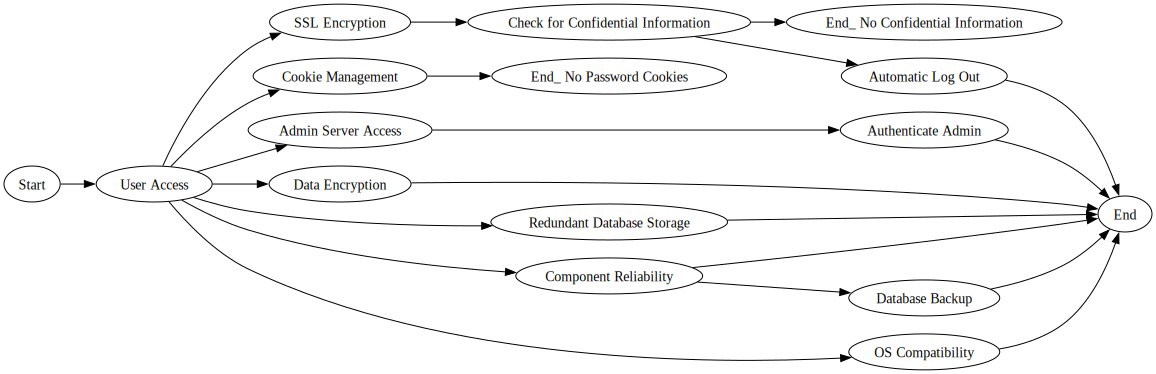

In [28]:
#change this so that it is a nested list of lists
annotation = [['Start', 'User Access'], 
              ['User Access', 'SSL Encryption'], 
              ['SSL Encryption', 'Check for Confidential Information'], 
              ['Check for Confidential Information', 'End: No Confidential Information'], 
              ['Check for Confidential Information', 'Automatic Log Out'], 
              ['Automatic Log Out', 'End'], 
              ['User Access', 'Cookie Management'], 
              ['Cookie Management', 'End: No Password Cookies'], 
              ['User Access', 'Admin Server Access'], 
              ['Admin Server Access', 'Authenticate Admin'], 
              ['Authenticate Admin', 'End'], 
              ['User Access', 'Data Encryption'], 
              ['Data Encryption', 'End'], 
              ['User Access', 'Redundant Database Storage'], 
              ['Redundant Database Storage', 'End'], 
              ['User Access', 'Component Reliability'], 
              ['Component Reliability', 'Database Backup'], 
              ['Database Backup', 'End'], 
              ['Component Reliability', 'End'], 
              ['User Access', 'OS Compatibility'], 
              ['OS Compatibility', 'End']]

temp_df = pd.DataFrame(annotation, columns=['from_node', 'to_node'])
temp_df['ProjectID'] = id_
annotation_df = pd.concat((annotation_df, temp_df), axis = 0)

render_graph(annotation)

In [29]:
id_ = applicable_projects[3]
sample = df_grouped.loc[df_grouped['ProjectID'] == id_]
sample

,ProjectID,RequirementText
1,19,The system must be easy to use by both managers and chefs such that they do not need to read an extensive amount of manuals. The system must be quickly accessible by both managers and chefs. The system must be intuitive and simple in the way it displays all relevant data and relationships. The menus of the system must be easily navigable by the users with buttons that are easy to understand. All the functions of the system must be available to the user every time the system is turned on. The calculations performed by the system must comply according to the norms set by the user and should not vary unless explicitly changed by the user. The client should agree to EULA before using our software.


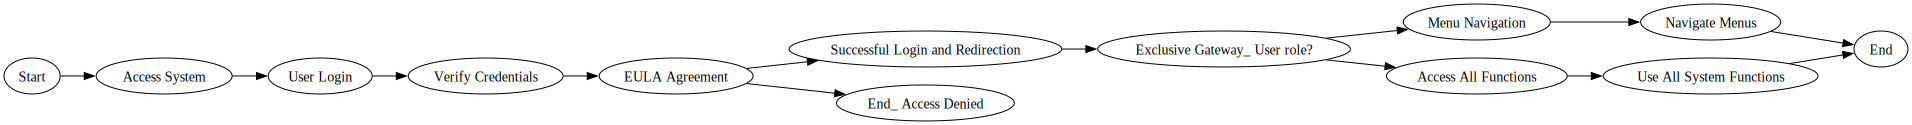

In [30]:
#change this so that it is a nested list of lists
annotation = [['Start', 'Access System'], 
              ['Access System', 'User Login'], 
              ['User Login', 'Verify Credentials'], 
              ['Verify Credentials', 'EULA Agreement'], 
              ['EULA Agreement', 'Successful Login and Redirection'], 
              ['EULA Agreement', 'End: Access Denied'], 
              ['Successful Login and Redirection', 'Exclusive Gateway: User role?'], 
              ['Exclusive Gateway: User role?', 'Menu Navigation'], 
              ['Exclusive Gateway: User role?', 'Access All Functions'], 
              ['Menu Navigation', 'Navigate Menus'], 
              ['Navigate Menus', 'End'], 
              ['Access All Functions', 'Use All System Functions'], 
              ['Use All System Functions', 'End']]

temp_df = pd.DataFrame(annotation, columns=['from_node', 'to_node'])
temp_df['ProjectID'] = id_
annotation_df = pd.concat((annotation_df, temp_df), axis = 0)

render_graph(annotation)

In [31]:
id_ = applicable_projects[4]
sample = df_grouped.loc[df_grouped['ProjectID'] == id_]
sample

,ProjectID,RequirementText
10,36,The Operational Interface shall have a Mean Time Between Failures of no less than 7 days. The system shall be available 99.5% of the time. The software system needs a robust security mechanism in place so that unauthorized users are not allowed access to parts of the system. Each user shall either be trusted or not trusted. All source code and development related documents shall be controlled under a version control system. All source code shall adhere to an agreed upon and well-defined set of coding standards for each development language used. Since the software must run on several popular hardware platforms and the goal is to achieve a reasonable level of platform independence.


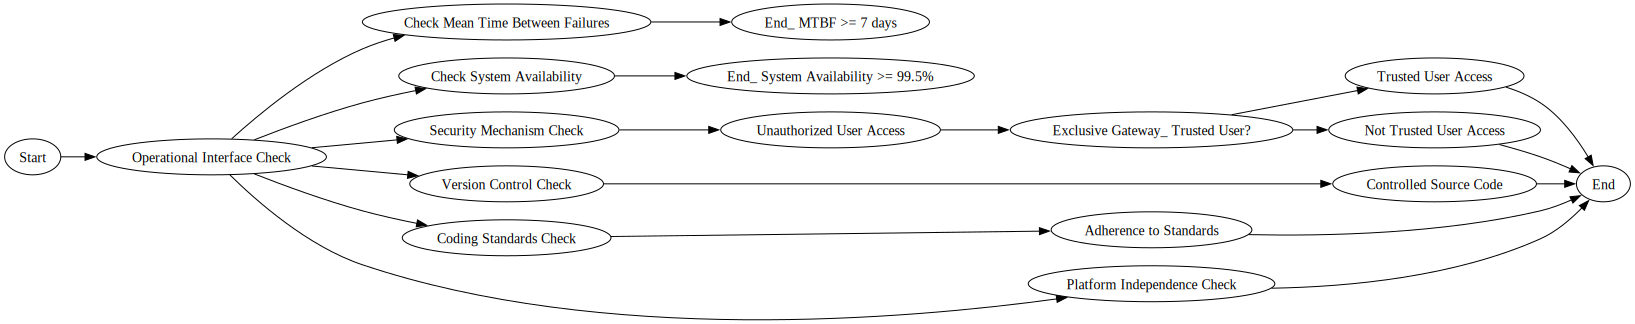

In [32]:
#change this so that it is a nested list of lists
annotation = [["Start", "Operational Interface Check"],
              ["Operational Interface Check", "Check Mean Time Between Failures"],
              ["Check Mean Time Between Failures", "End: MTBF >= 7 days"],
              ["Operational Interface Check", "Check System Availability"],
              ["Check System Availability", "End: System Availability >= 99.5%"],
              ["Operational Interface Check", "Security Mechanism Check"],
              ["Security Mechanism Check", "Unauthorized User Access"],
              ["Unauthorized User Access", "Exclusive Gateway: Trusted User?"],
              ["Exclusive Gateway: Trusted User?", "Trusted User Access"],
              ["Exclusive Gateway: Trusted User?", "Not Trusted User Access"],
              ["Trusted User Access", "End"],
              ["Not Trusted User Access", "End"],
              ["Operational Interface Check", "Version Control Check"],
              ["Version Control Check", "Controlled Source Code"],
              ["Controlled Source Code", "End"],
              ["Operational Interface Check", "Coding Standards Check"],
              ["Coding Standards Check", "Adherence to Standards"],
              ["Adherence to Standards", "End"],
              ["Operational Interface Check", "Platform Independence Check"],
              ["Platform Independence Check", "End"]]

temp_df = pd.DataFrame(annotation, columns=['from_node', 'to_node'])
temp_df['ProjectID'] = id_
annotation_df = pd.concat((annotation_df, temp_df), axis = 0)

render_graph(annotation)

In [34]:
annotation_df.head()

,from_node,to_node,ProjectID
0,Start,Display Logo and Basic Design,35
1,Display Logo and Basic Design,Attractive Design According to Clients,35
2,Attractive Design According to Clients,Comfortable User Experience,35
3,Comfortable User Experience,Reflect Seriousness of Environment,35
4,Reflect Seriousness of Environment,Manage Information from Database and Catalogue,35


In [33]:
annotation_df.to_csv('../data/annotations.csv', index=False)